In [22]:
# coding=utf-8
from __future__ import print_function, absolute_import
from gm.api import *

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False

import seaborn as sns
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from tqdm import tqdm

## calc
from scipy.stats import linregress

In [14]:
data = pd.read_parquet(r'E:\repo\stocks_dashborads\data\index\上证指数.parquet')
data

,,open,high,low,close,volume,amount,pre_close
date,symbol,,,,,,,
2024-01-02,SHSE.000001,2972.775,2976.268,2962.276,2962.276,30414179300,3.45950729e+11,2974.935
2024-01-03,SHSE.000001,2957.112,2971.283,2953.290,2967.247,28545594500,3.21018391e+11,2962.276
2024-01-04,SHSE.000001,2965.509,2966.683,2936.635,2954.349,26498092400,2.96291347e+11,2967.247
2024-01-05,SHSE.000001,2949.822,2967.968,2916.721,2929.183,30104023900,3.25917001e+11,2954.349
2024-01-08,SHSE.000001,2923.457,2924.456,2887.538,2887.538,27027505500,2.90730590e+11,2929.183
...,...,...,...,...,...,...,...,...
2025-08-28,SHSE.000001,3796.711,3845.087,3761.422,3843.597,78835194700,1.26518553e+12,3800.350
2025-08-29,SHSE.000001,3842.823,3867.606,3839.206,3857.927,73946236600,1.22169185e+12,3843.597
2025-09-01,SHSE.000001,3869.746,3879.045,3853.658,3875.531,74770953600,1.20834798e+12,3857.927


In [7]:
upDownCount_df = pd.read_parquet(r'E:\repo\stocks_dashborads\data\factors\emotion\upDownCount.parquet')
upDownCount_df

,upDownCount_
date,
2024-01-02,0
2024-01-03,1835
2024-01-04,1752
2024-01-05,475
2024-01-08,362
...,...
2025-08-27,596
2025-08-28,2712
2025-08-29,1849


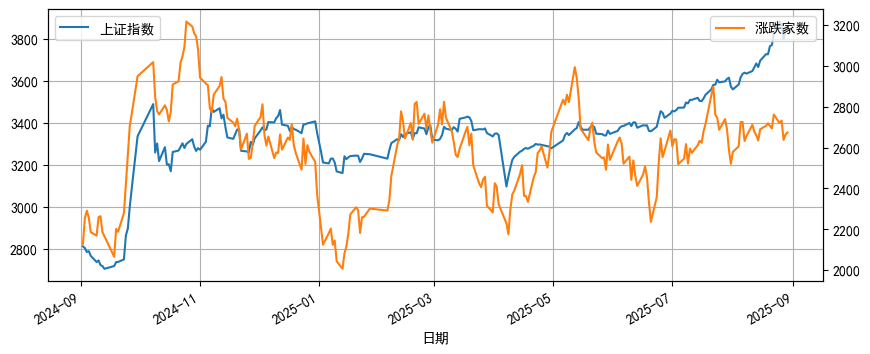

In [29]:
ax = data.loc['2024-09-01':'2025-08-31'].droplevel(1).close.plot(figsize=(10,4), label='上证指数')
ax_right = ax.twinx()
ax_right.plot(upDownCount_df.rolling(22).mean().loc['2024-09-01':'2025-08-31'], c='C1', label='涨跌家数')
ax_right.legend()
ax.legend()
ax.set_xlabel('日期')
ax.grid()
plt.show()

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def plot_turning_points(data: pd.DataFrame, distance=5, prominence=0.0):
    """
    data: DataFrame, 必须包含 ['open','high','low','close']，index 是时间
    distance: 峰之间的最小间距
    prominence: 峰的显著性，数值越大，过滤越严格
    """
    close = data["close"]

    # 找高点
    peaks, _ = find_peaks(close.values, distance=distance, prominence=prominence)
    # 找低点（对收盘价取反）
    troughs, _ = find_peaks(-close.values, distance=distance, prominence=prominence)

    # 绘图
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(data.index, close, label="Close", color="black", linewidth=1)

    # 标注高点
    ax.scatter(data.index[peaks], close.iloc[peaks],
               marker="^", color="red", s=100, label="Peak")
    # 标注低点
    ax.scatter(data.index[troughs], close.iloc[troughs],
               marker="v", color="green", s=100, label="Trough")

    ax.set_title(f"Close with Turning Points (prominence={prominence}, distance={distance})")
    ax.legend()
    plt.show()


# === 使用示例 ===
# plot_turning_points(data, distance=5, prominence=10)


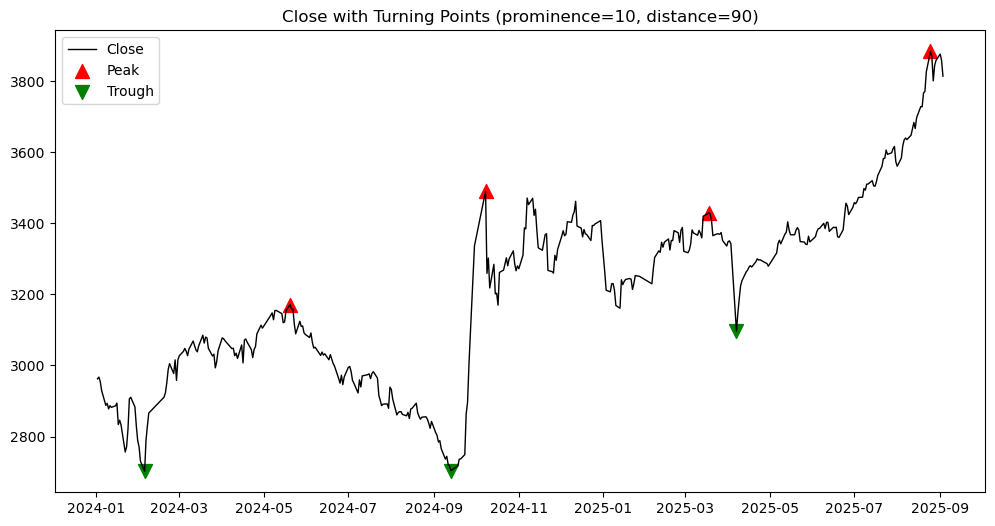

In [27]:
plot_turning_points(data.droplevel(1), distance=90, prominence=10)